In [1]:
#!pip install xlrd
import numpy as np
import pandas as pd
import sys
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris
import hyperimpute.logger as log

X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame = True, return_X_y = True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "airfoil": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        header=None,
        sep="\\t",
    ),
    "blood": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
    ),
    "bc": X_raw_breast_cancer,
    "california": X_raw_california,
    "climate": climate_model_df,
    "compression": pd.read_excel(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    ),
    "slump": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data"
    ),
    "sonar": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
        header=None,
    ),
    "diabetes": X_raw_diab,
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "yeast": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data",
        sep="\s+",
        header=None,
    ),
    "iris": X_raw_iris,
    "libras":pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",sep=",", header = None),
    "parkinsons": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",sep=","),
    "yacht": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",sep="\s+", header = None),
    "ionosphere": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",sep=",", header = None),
    "letter": pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data", header = None),
    "spam":pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"),
    "credit":pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data", header = None),
}

/code/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
from benchmark_imputation import simulate_scenarios
from hyperimpute.plugins.imputers import Imputers
import warnings
import pandas as pd

imputers = Imputers()

warnings.filterwarnings('ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def get_imputer():
    return imputers.get("hyperimpute", 
        optimizer = "simple"
    )

def evaluate_dataset(name: str, X_raw: pd.DataFrame, 
    scenarios: list = ["MAR", "MCAR"],
    miss_pct: list = [0.1, 0.3, 0.5, 0.7],
    debug: bool = True,
):
    imputation_scenarios = simulate_scenarios(X_raw, column_limit = 10)

    out = {}
    for scenario in scenarios:
        out[scenario] = {}
        for missingness in miss_pct:
        
            try:
                x, x_miss, mask = imputation_scenarios[scenario][missingness]

                model = get_imputer()
                
                model.fit_transform(x_miss)
                
                mod_names = []
                for mod_idx in model.trace():
                    mod =  model.trace()[mod_idx][0]
                    mod_names.append(mod.name())
                out[scenario][missingness] = mod_names
                print("       > eval ", scenario, missingness, mod_names)
                
            except BaseException as e:
                print("scenario failed", str(e))
                continue
    return out

In [ ]:
from sklearn.preprocessing import LabelEncoder

selected_models = {}
for dataset in raw_datasets:
    print("  > eval ", dataset)

    df = raw_datasets[dataset]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = LabelEncoder().fit_transform(df[col])
    
    selected_models[dataset] = evaluate_dataset(dataset, df)

In [ ]:
import json

with open("general_results/selected_models.json", "w") as f:
    json.dump(selected_models, f)

In [ ]:
selected_models

In [ ]:
from IPython.display import HTML, display
import tabulate

print_headers = ["Dataset", "0.1 missingness", "0.3 missingness", "0.5 missingness", "0.7 missingness"]


def pretty_models(model_list):
    out = []
    for model in np.unique(model_list):
        if model == "xgboost":
            model = "XGBClassifier"
        elif model == "xgboost_regressor":
            model = "XGBRegressor"
        elif model == "catboost":
            model = "CatboostClassifier"
        elif model == "catboost_regressor":
            model = "CatboostRegressor"
        elif model == "random_forest":
            model = "RFClassifier"
        elif model == "random_forest_regressor":
            model = "RFRegressor"
        elif model == "logistic_regression":
            model = "LogisticRegression"
        elif model == "linear_regression":
            model = "LinearRegression"
        elif model == "neural_nets":
            model = "NNClassifier"
        else:
            raise RuntimeError(model)
        out.append(model)
        
    return sorted(out)


def print_scenario(scenario):
    print_data = []

    for dataset in selected_models:
        local_print_data = [dataset]
        for missingness in selected_models[dataset][scenario]:
            models = '\n'.join(pretty_models(selected_models[dataset][scenario][missingness]))
            local_print_data.append(models)

        print_data.append(local_print_data)

    display(tabulate.tabulate(print_data, headers=print_headers, tablefmt="html"))

In [ ]:
print_scenario("MAR")

In [ ]:
print_scenario("MCAR")

In [ ]:
import copy

template = """
\midrule
\multirow{4}{*}{DATASET}  
& $0.1$ & MAR_0.1 & MCAR_0.1  \\
& $0.3$ & MAR_0.3 & MCAR_0.3  \\
& $0.5$ & MAR_0.5 & MCAR_0.5 \\
& $0.7$ & MAR_0.7 & MCAR_0.7 \\

"""

sorted_dfs = sorted(selected_models.keys())
def print_scenarios():
    print_data = []

    for dataset in sorted_dfs:
        latex_val = copy.copy(template)
        
        latex_val = latex_val.replace("DATASET", dataset)
        for scenario in selected_models[dataset]:
            for missingness in selected_models[dataset][scenario]:
                key = f"{scenario}_{missingness}"
                latex_val = latex_val.replace(key, ",".join(pretty_models(selected_models[dataset][scenario][missingness])))
        print(latex_val)
print_scenarios()

In [4]:
from hyperimpute.plugins.utils.metrics import RMSE
from benchmark_imputation import ws_score

step = 10
def get_imputer(cbk):
    return imputers.get("hyperimpute", 
        optimizer = "simple",
        outer_loop_hook = cbk,
        n_inner_iter = step,
        n_outer_iter = 40,
    )

def evaluate_convergence(name: str, X_raw: pd.DataFrame, 
    scenarios: list = ["MAR"],
    miss_pct: list = [0.3],
    debug: bool = True,
):
    imputation_scenarios = simulate_scenarios(X_raw, column_limit = 10)

    out = {}
    for scenario in scenarios:
        out[scenario] = {}
        for missingness in miss_pct:
        
            try:
                x, x_miss, mask = imputation_scenarios[scenario][missingness]

                wass_scores = []
                rmse_scores = []
                def hook(outer_it, Xt):
                    nonlocal rmse_scores
                    nonlocal wass_scores
                    distribution_score = ws_score(Xt, x)
                    rmse_score = RMSE(np.asarray(Xt), np.asarray(x), np.asarray(mask))
                    
                    wass_scores.append(distribution_score)
                    rmse_scores.append(rmse_score)
                    #print(outer_it, distribution_score, rmse_score)
        
                model = get_imputer(hook)
                
                model.fit_transform(x_miss.copy())
                
                trace = model.perf_trace()
                
                max_wait = len(wass_scores)
                
                for mod_idx in trace:
                    if len(trace[mod_idx]) < max_wait:
                        trace[mod_idx] += [trace[mod_idx][-1]] * (max_wait - len(trace[mod_idx]))
                        
                for mod_idx in trace:
                    arr = np.asarray(trace[mod_idx])
                    if arr[0] > 0:
                        arr = 1 - arr
                    else:
                        arr = -arr
                    trace[mod_idx] = arr
                    
                    
                scores = []
                for mod_idx in model.perf_trace():
                    score_len =  len(model.perf_trace()[mod_idx])
                    break
                    
                for epoch in range(score_len):
                    epoch_score = 0
                    for mod_idx in model.perf_trace():
                        epoch_score +=  model.perf_trace()[mod_idx][epoch]
                    scores.append(epoch_score)
            except BaseException as e:
                raise e
                print("scenario failed", str(e))
                continue
    return scores, wass_scores, rmse_scores 


In [8]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("diagrams/convergence")

def perf_plot_dataset(dataset, scenario, miss):
    df = raw_datasets[dataset]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = LabelEncoder().fit_transform(df[col])

    optimizer_scores, wass_scores, rmse_scores = evaluate_convergence(dataset, df, scenarios = [scenario], miss_pct = [miss])

    fig, axs = plt.subplots(1, 3, figsize = (15, 4))

    axs[0].plot([ step * i for i in range(len(optimizer_scores))], optimizer_scores, label = "Cumulative objective error", color = "orange")
    axs[0].legend()
    axs[1].plot([ step * i for i in range(len(optimizer_scores))], wass_scores, label = "Wasserstein distance")
    axs[1].legend()
    axs[2].plot([ step * i for i in range(len(optimizer_scores))], rmse_scores, label = "RMSE", color = "green")
    axs[2].legend()

    axs[0].set_ylabel(f"{scenario}: {dataset}: {miss}")
    axs[1].set_xlabel(f"Total(Outer x Inner) iterations")

    plt.savefig(output_dir / f"convergence_{scenario}_{dataset}_{miss}.png")

    plt.show()

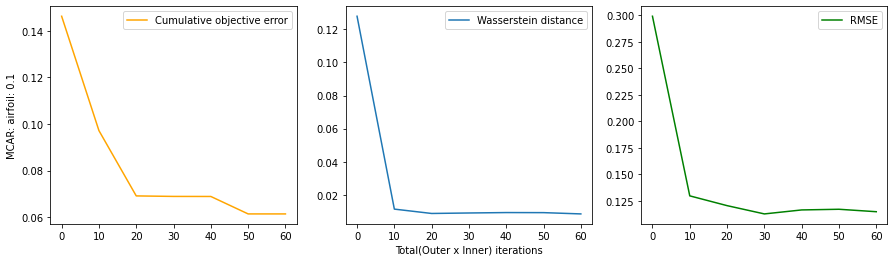

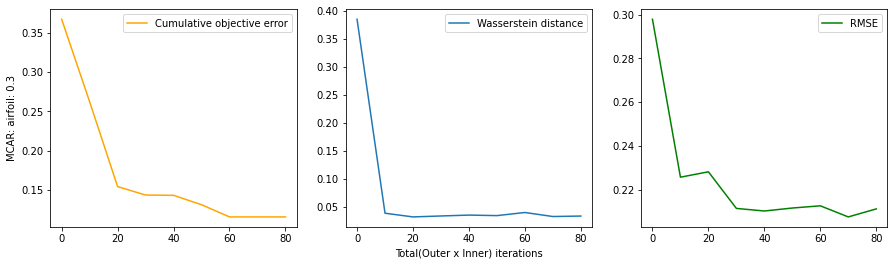

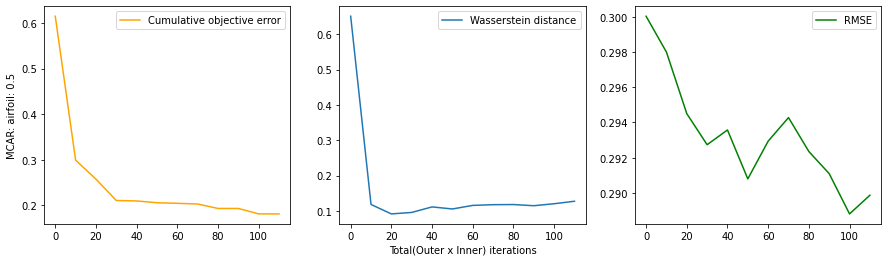

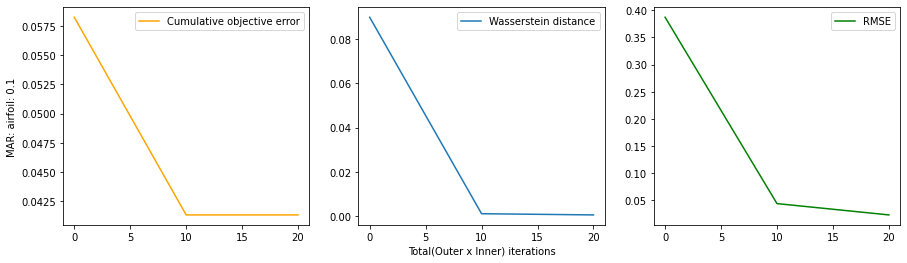

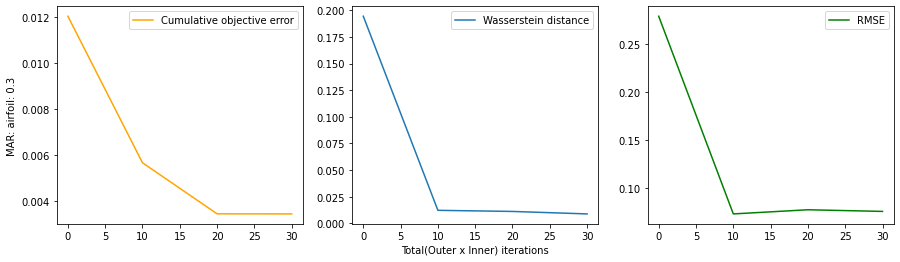

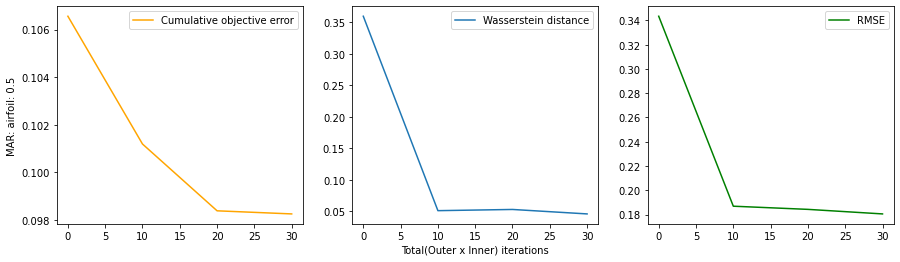

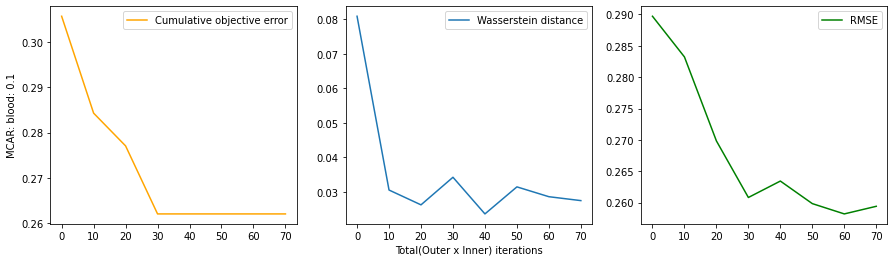

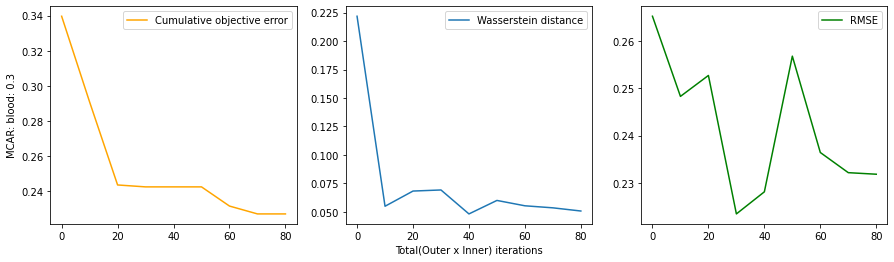

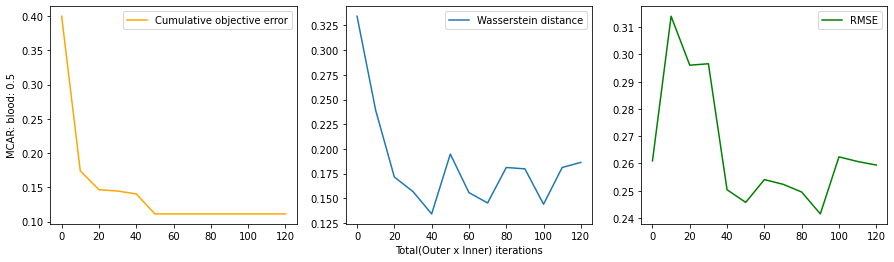

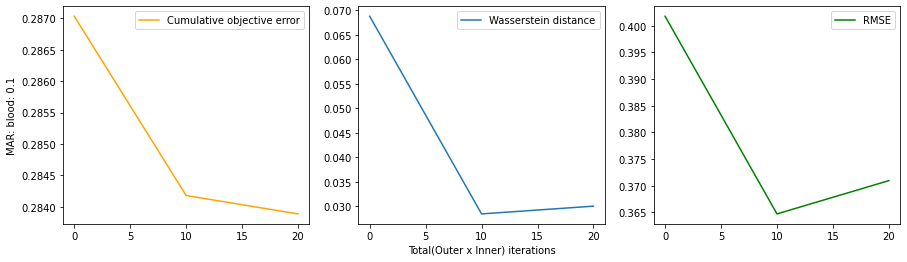

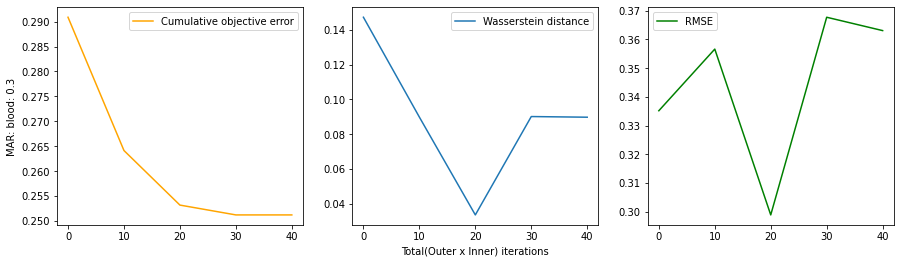

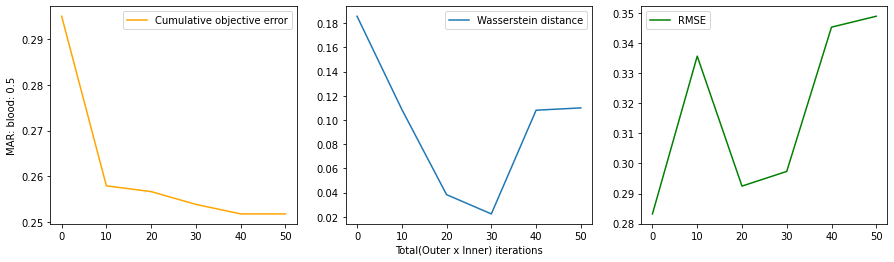

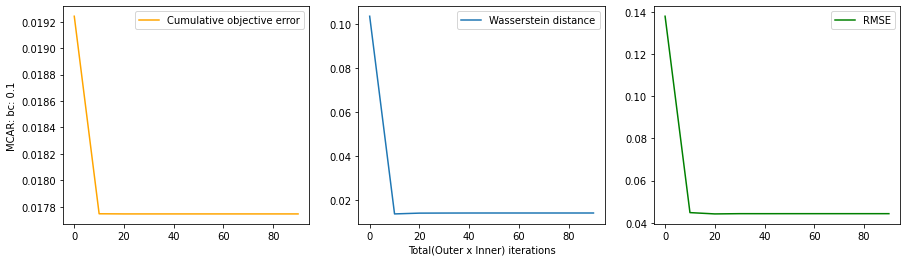

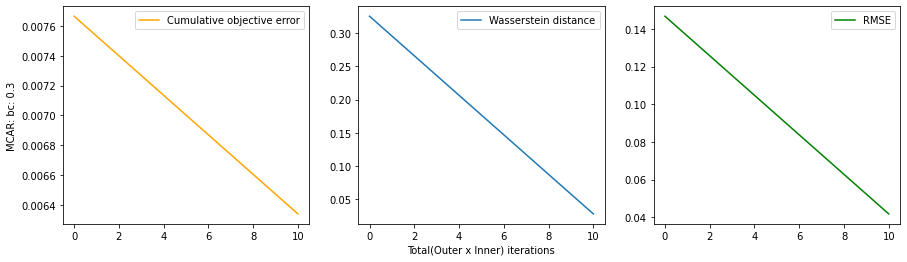

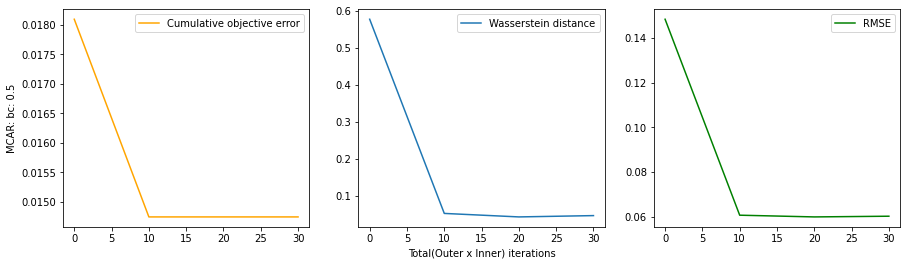

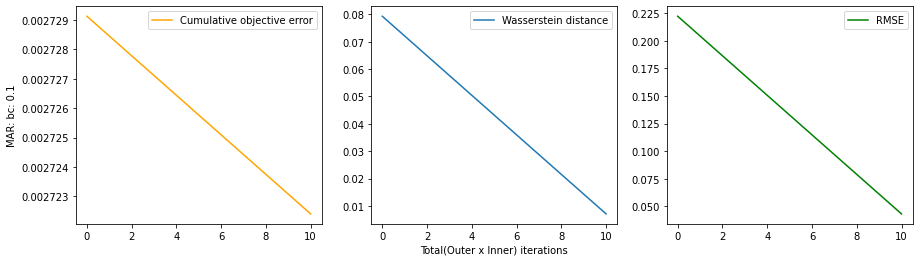

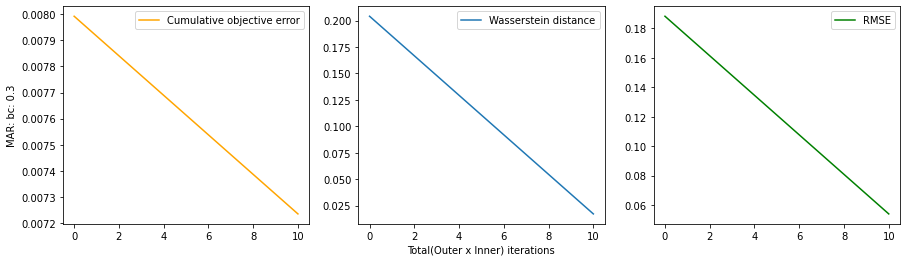

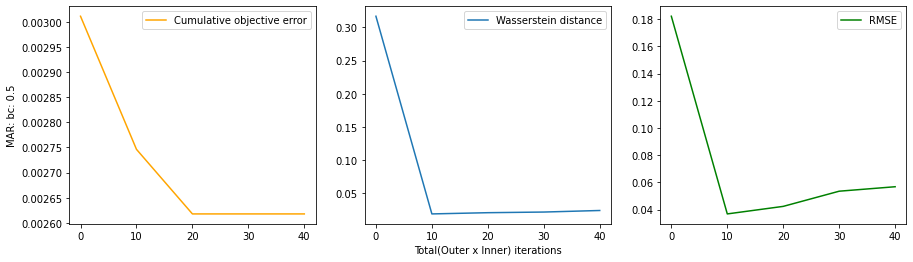

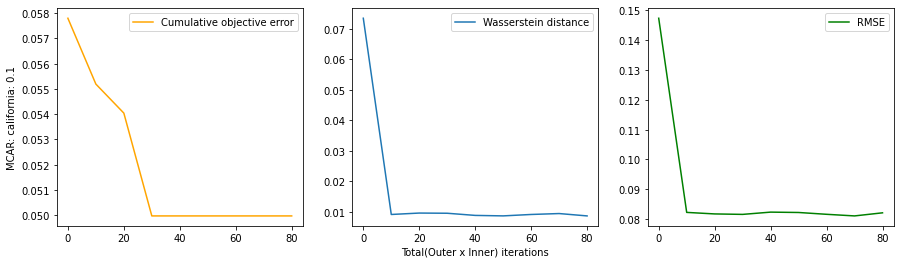

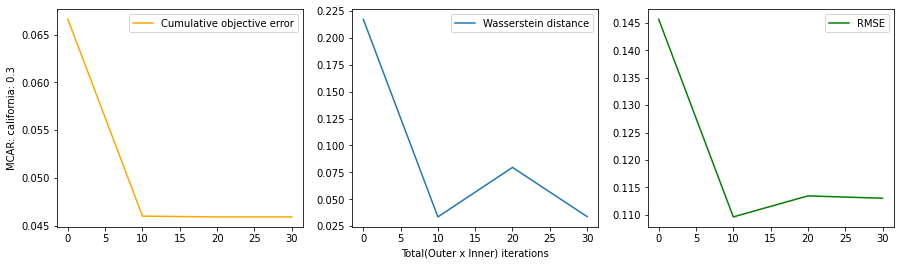

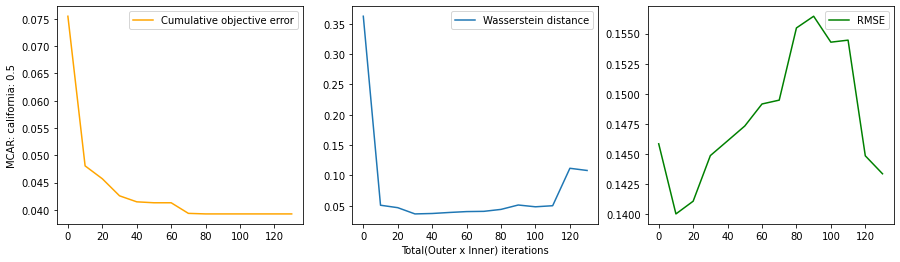

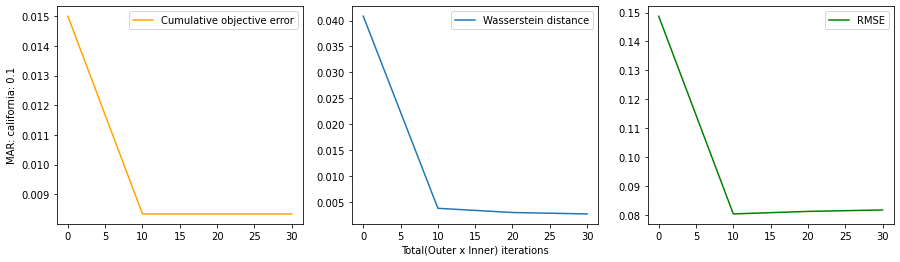

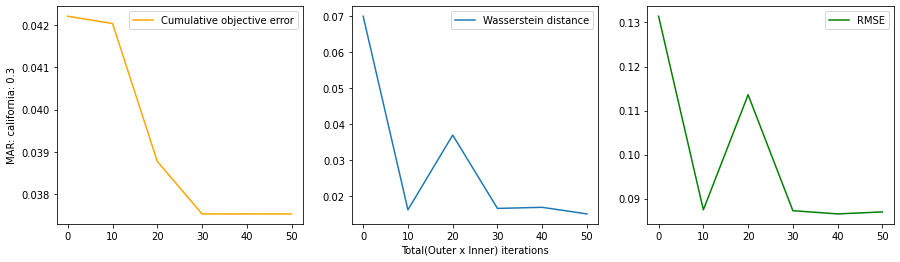

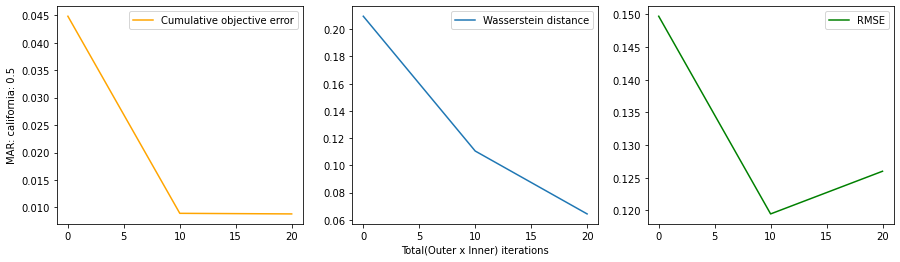

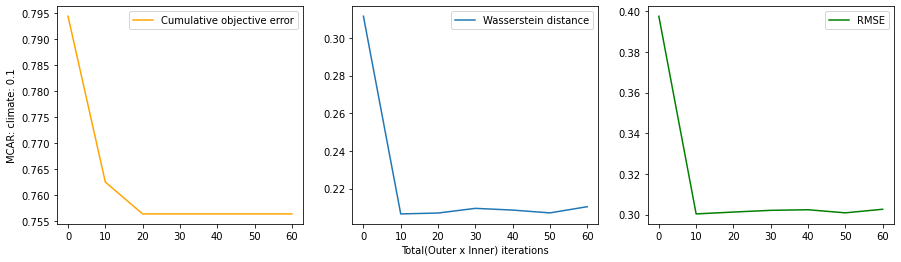

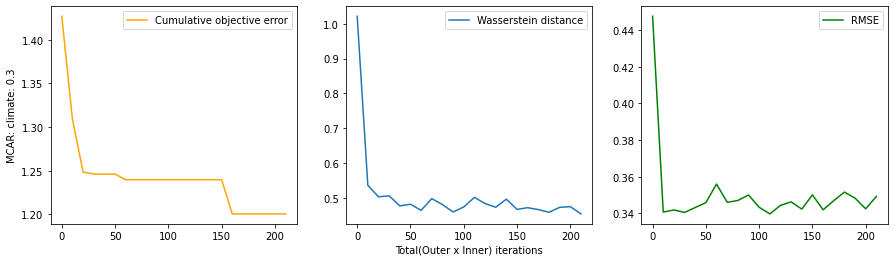

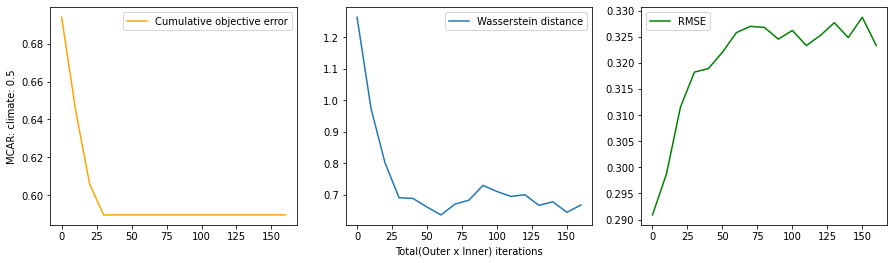

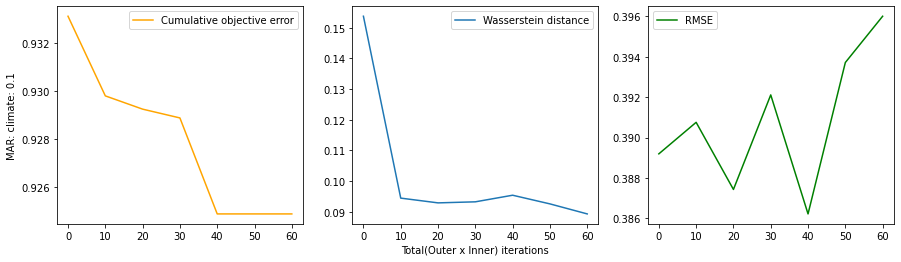

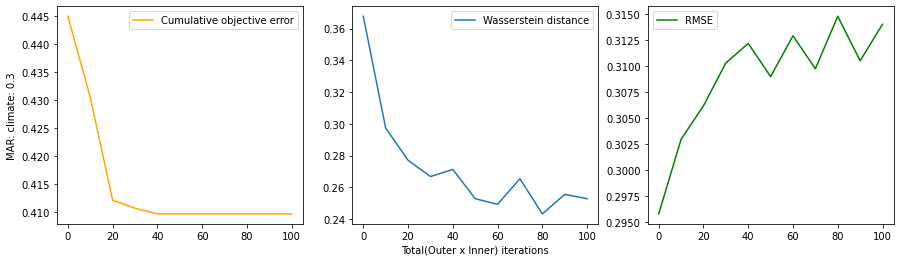

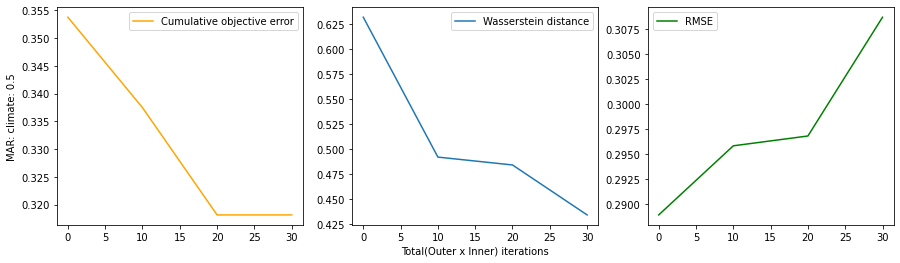

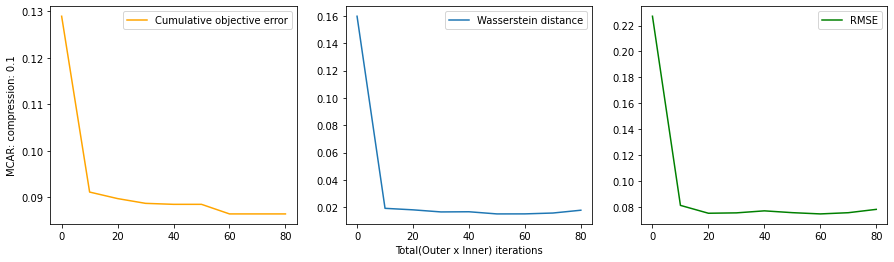

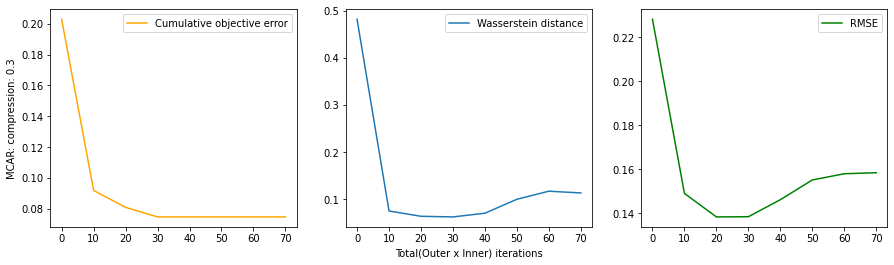

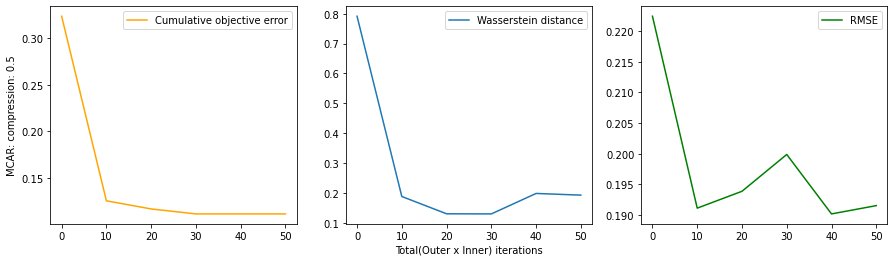

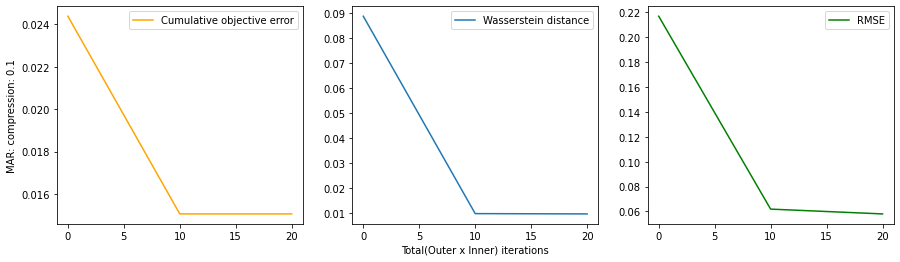

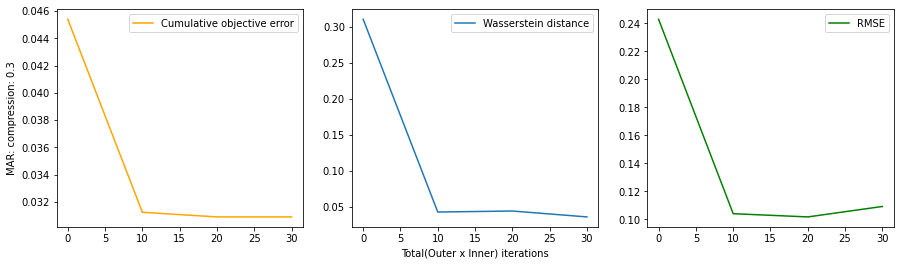

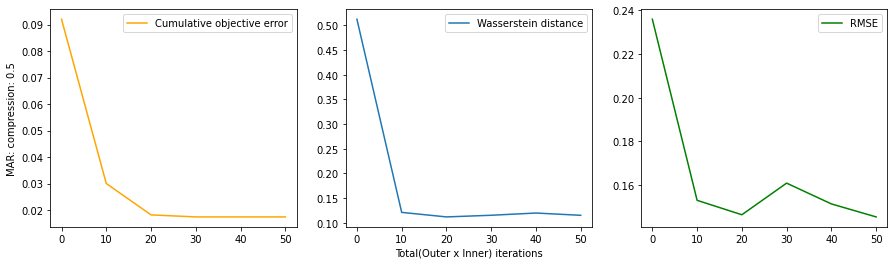

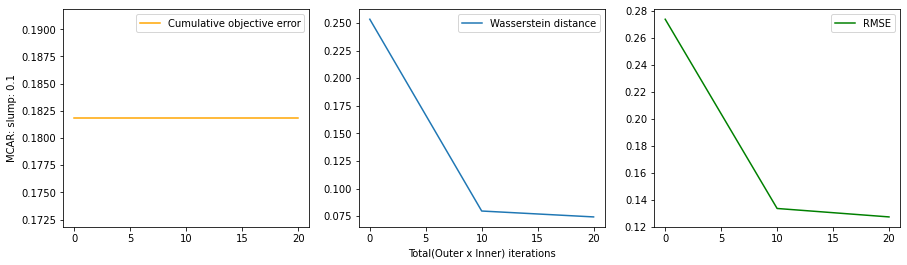

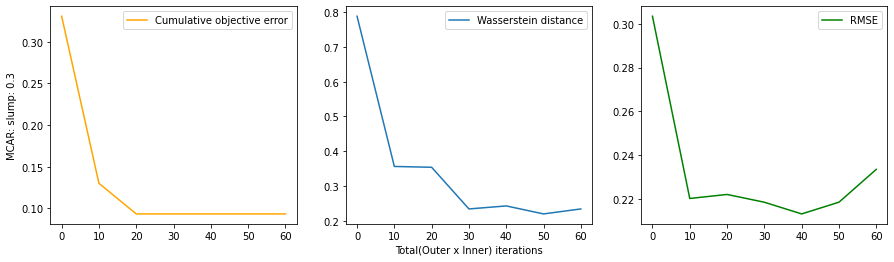

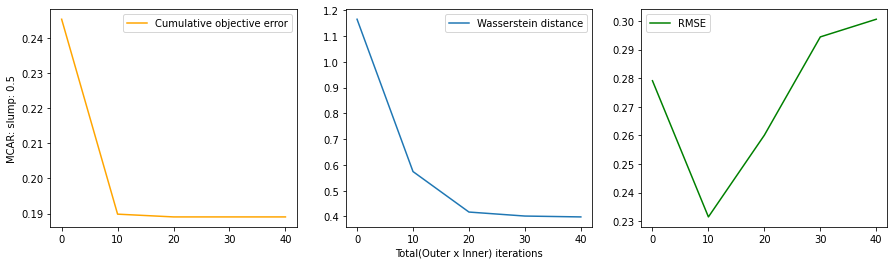

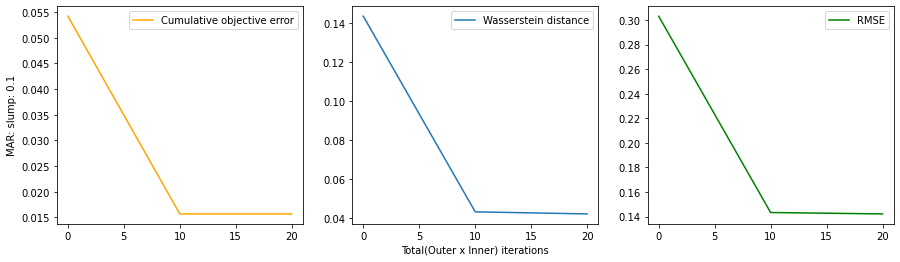

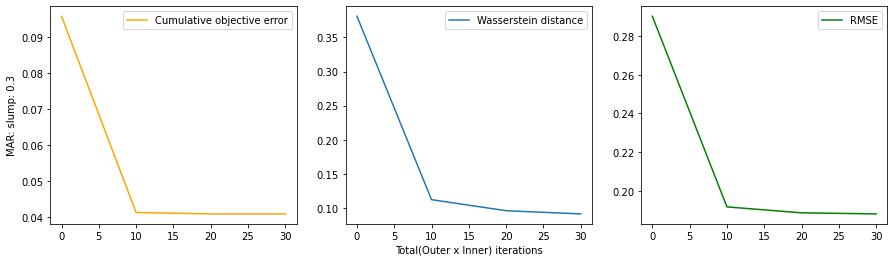

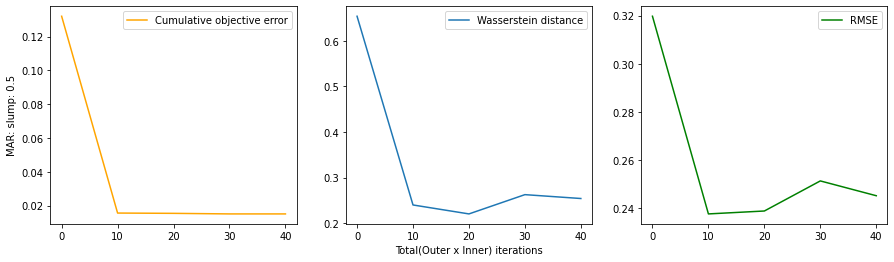

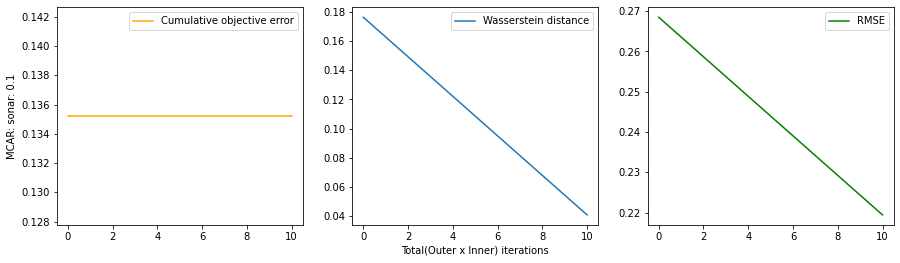

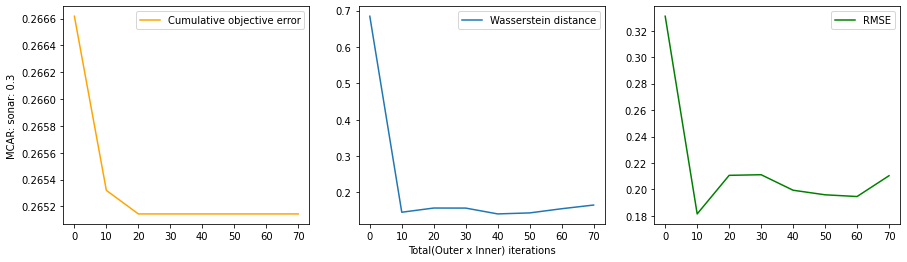

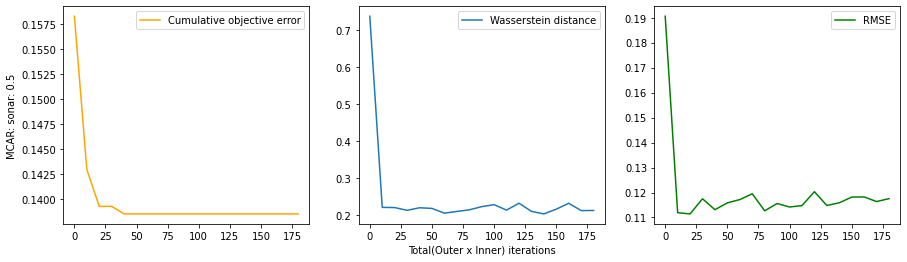

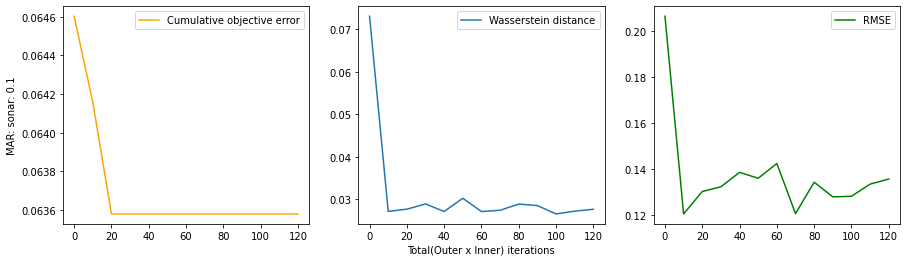

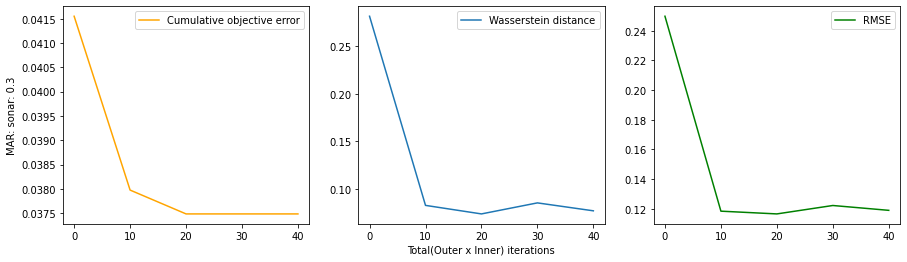

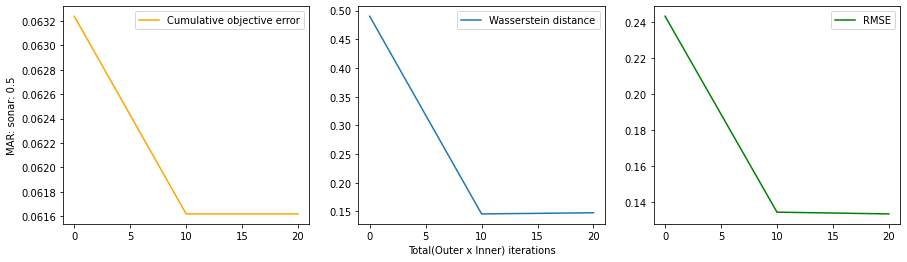

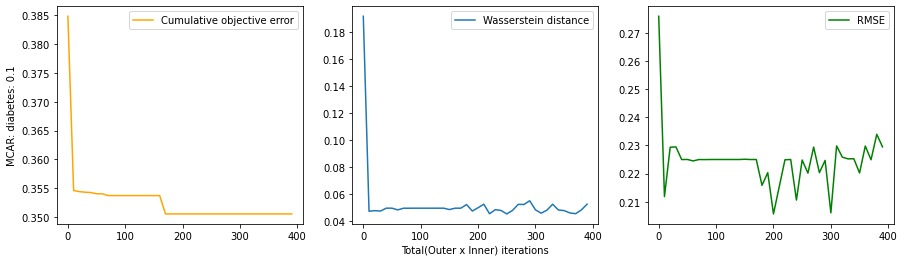

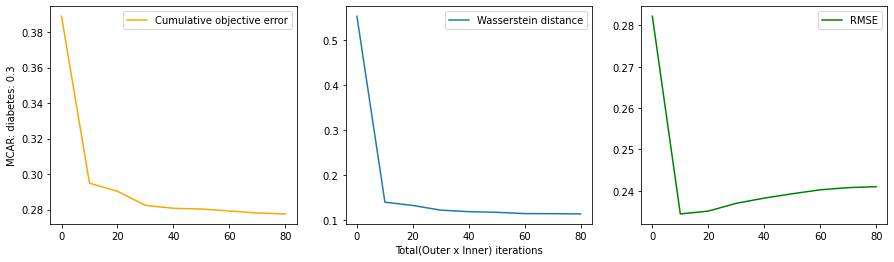

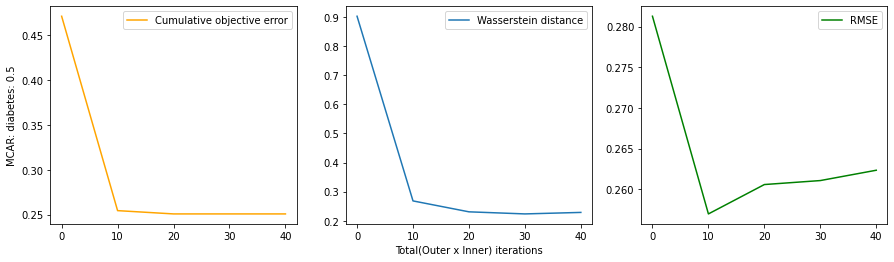

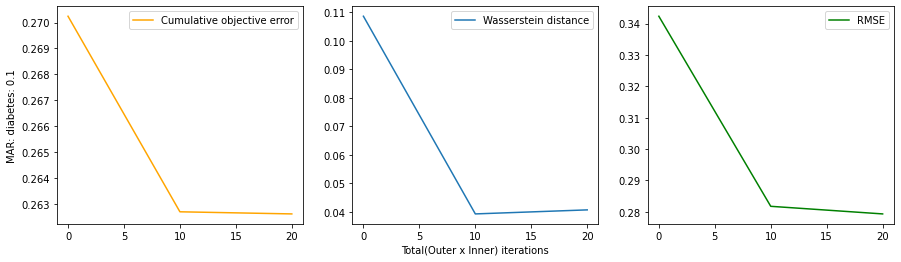

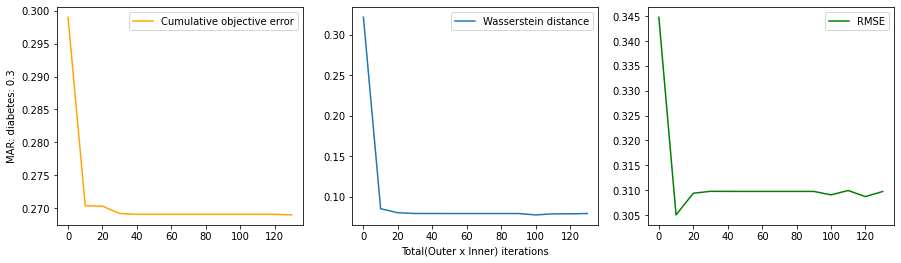

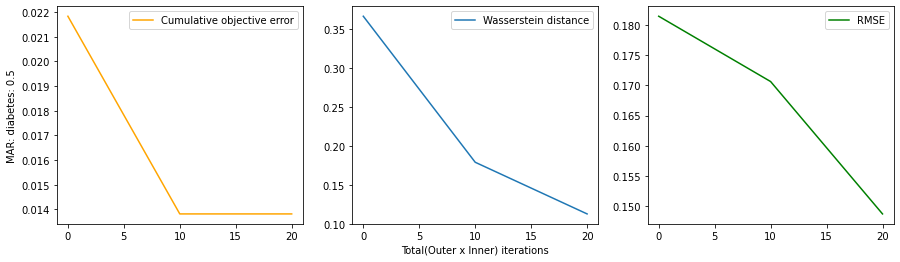

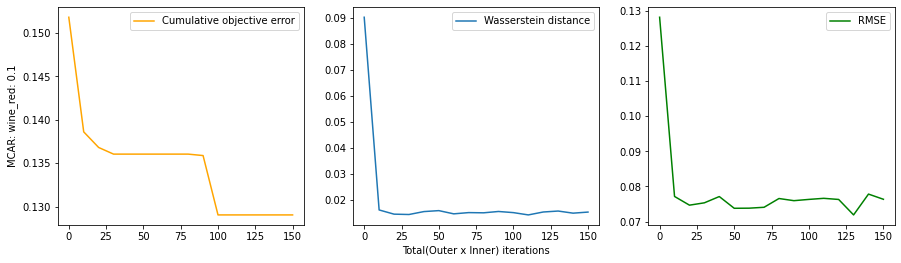

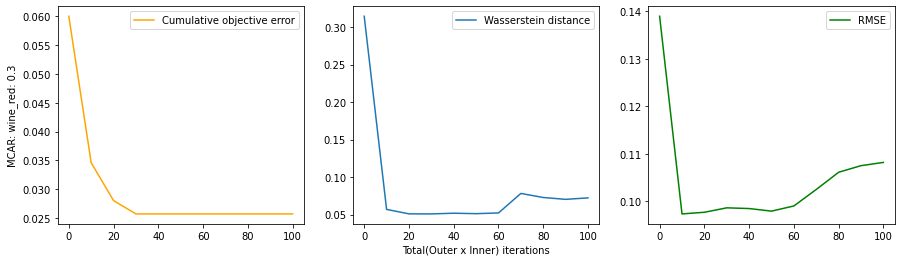

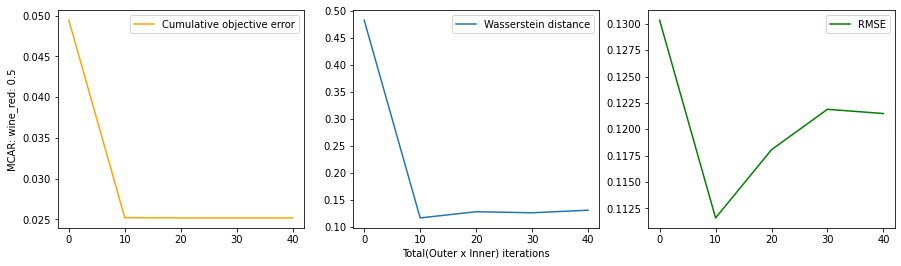

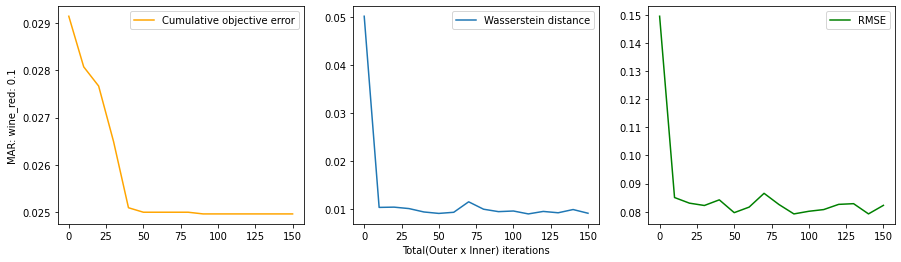

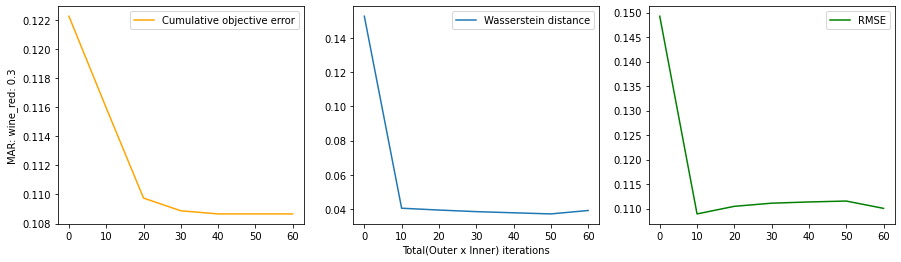

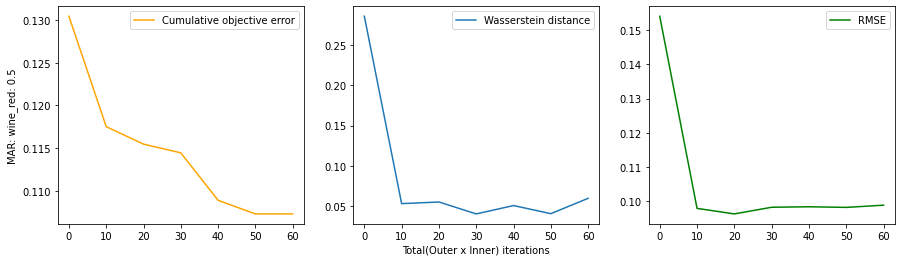

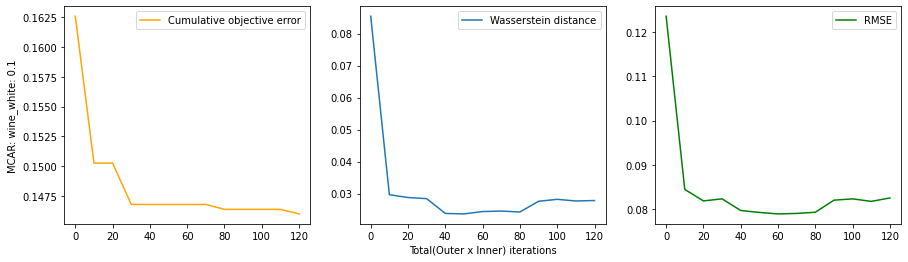

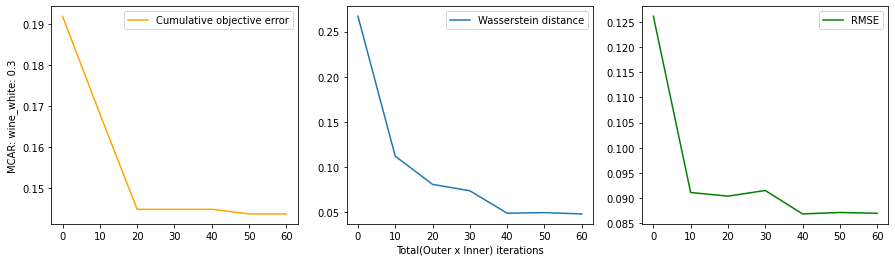

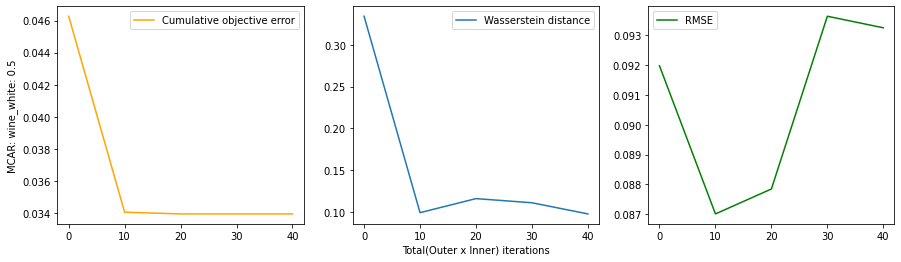

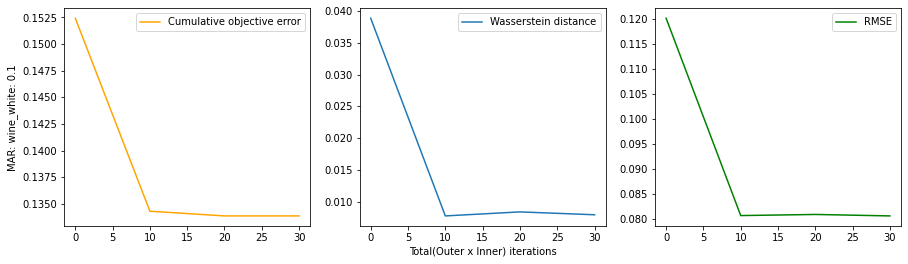

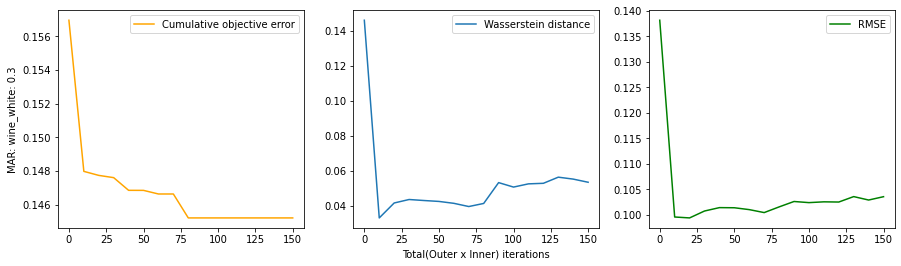

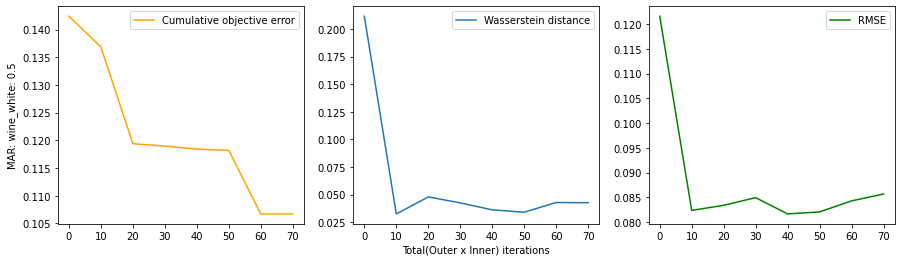

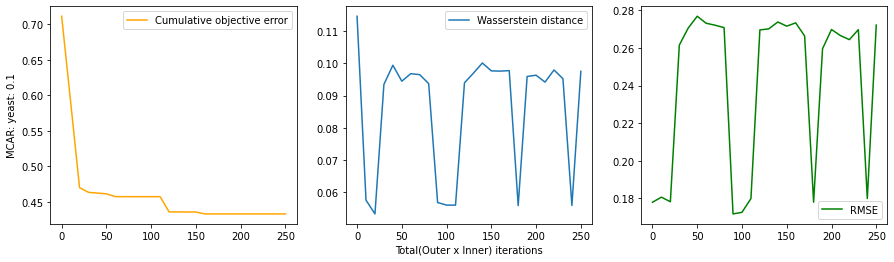

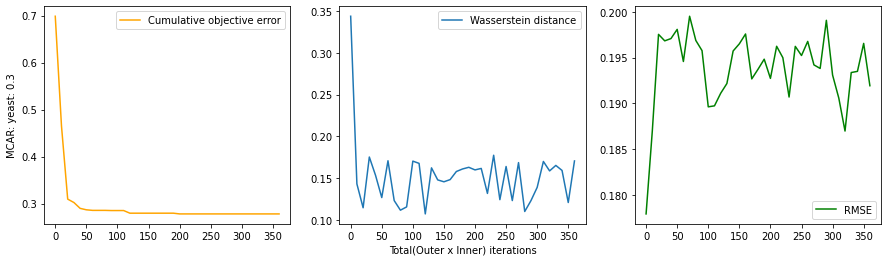

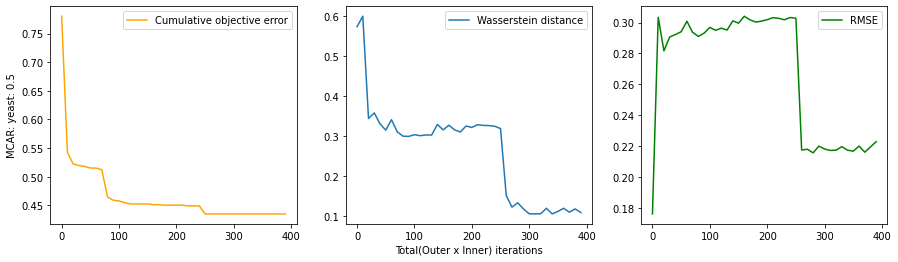

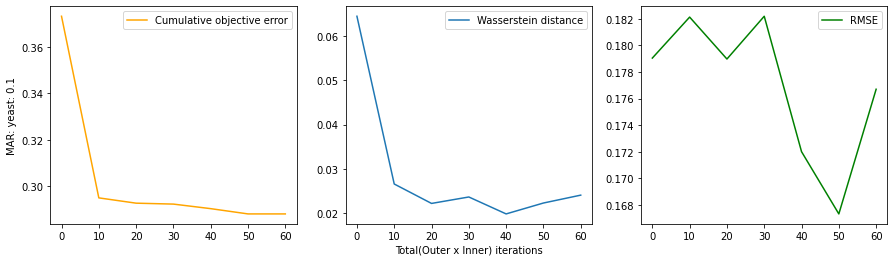

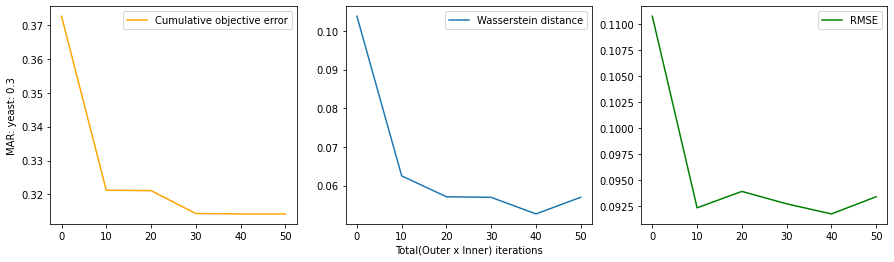

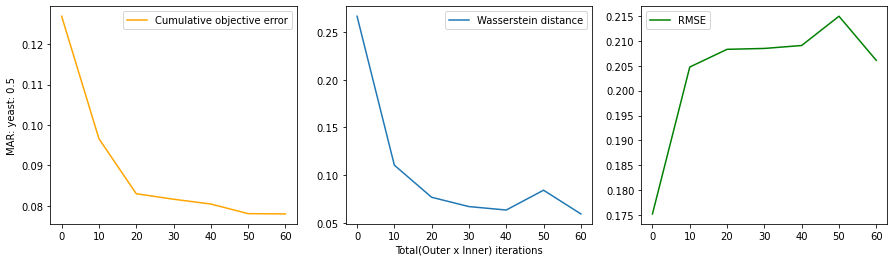

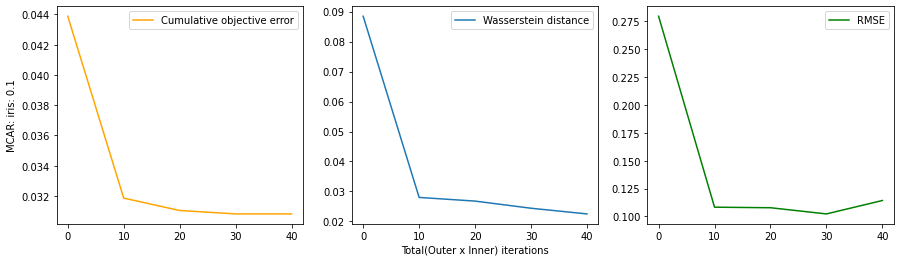

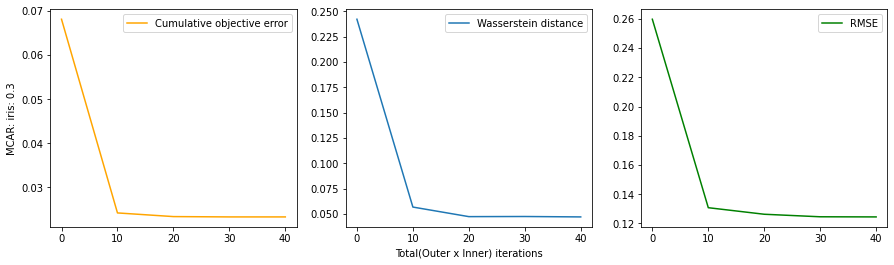

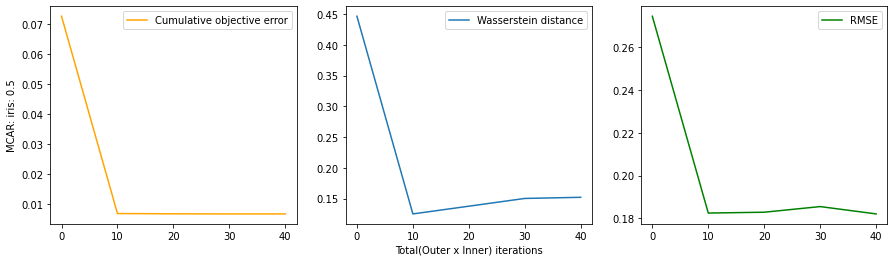

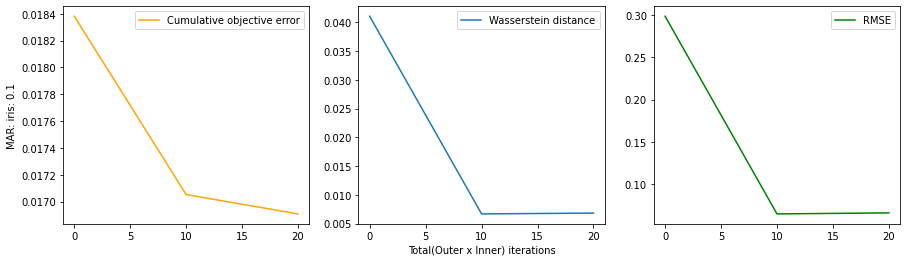

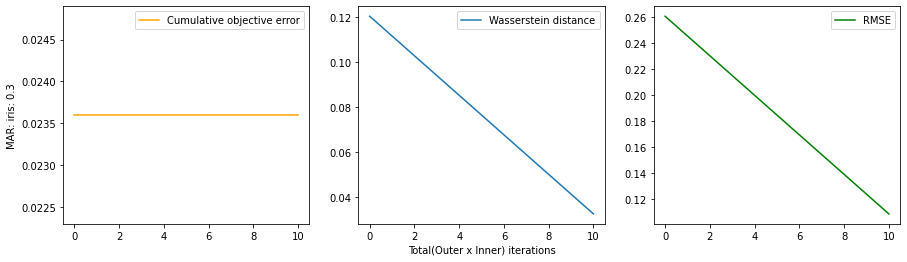

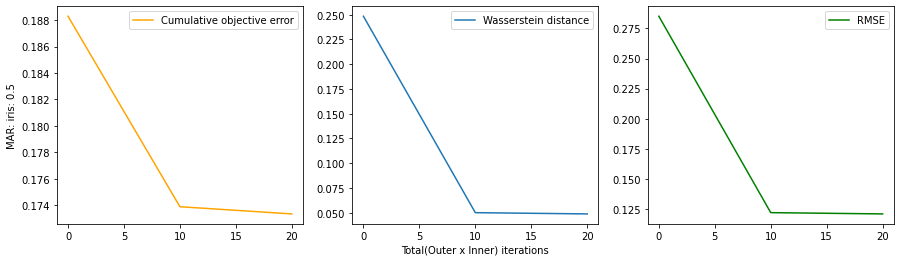

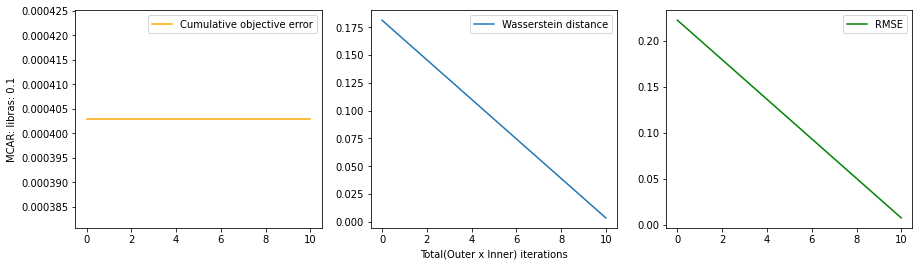

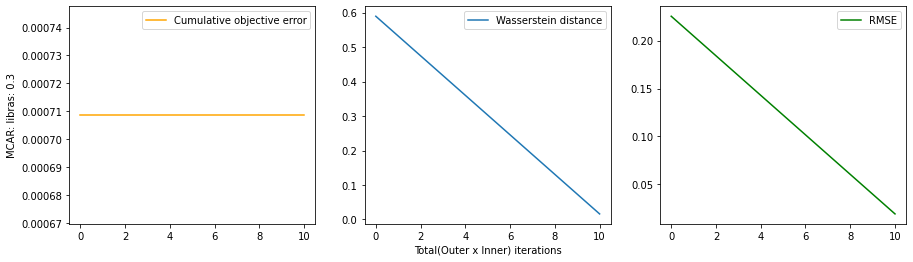

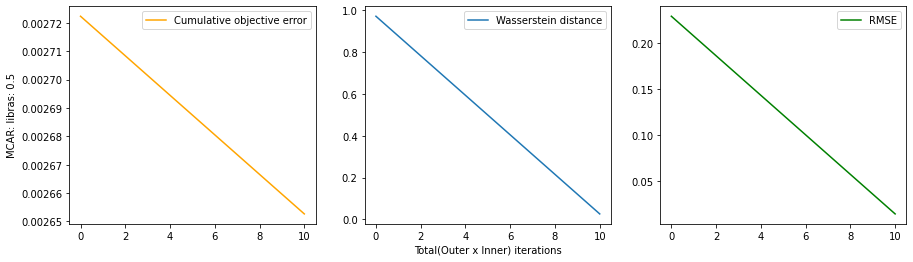

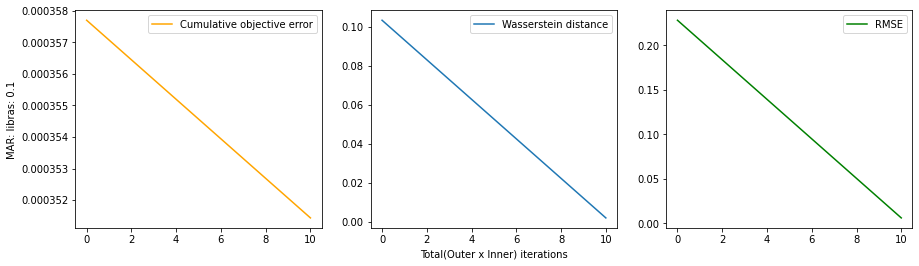

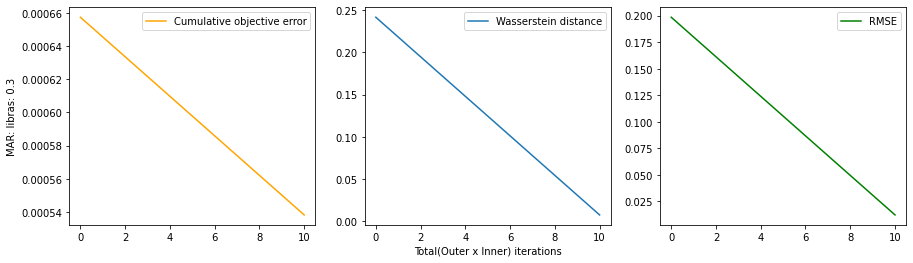

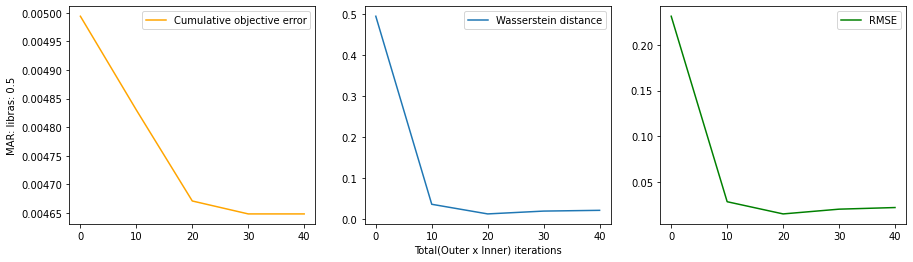

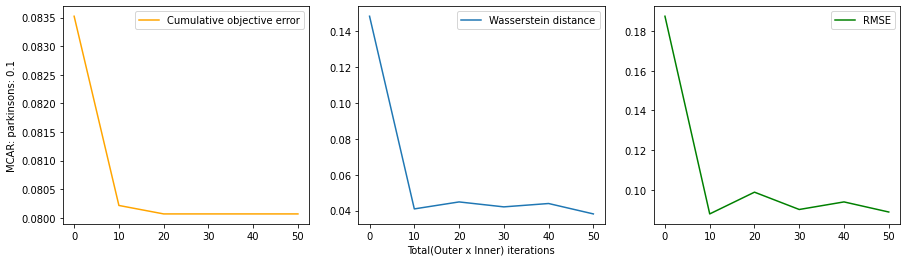

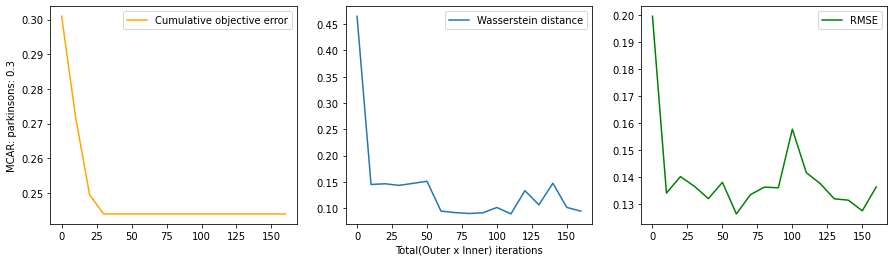

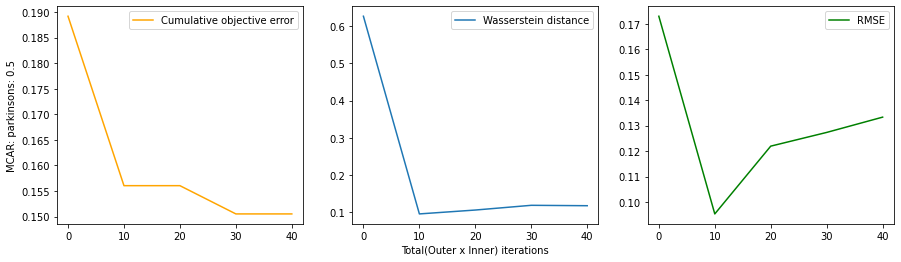

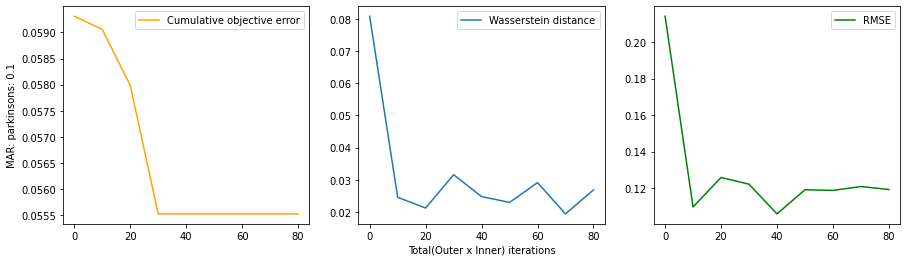

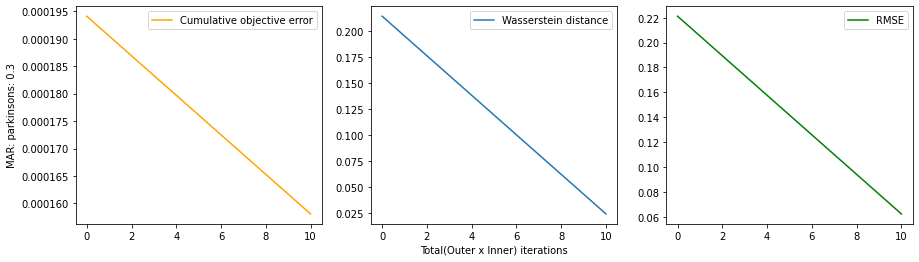

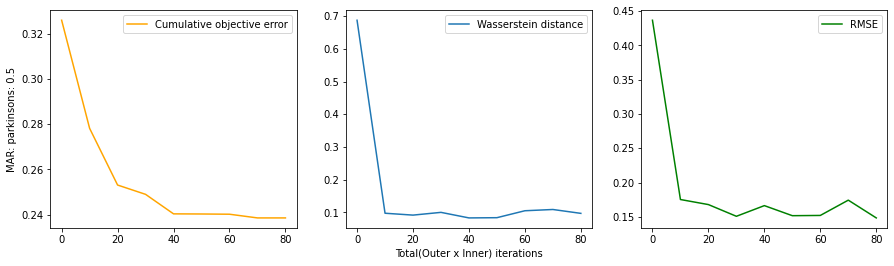

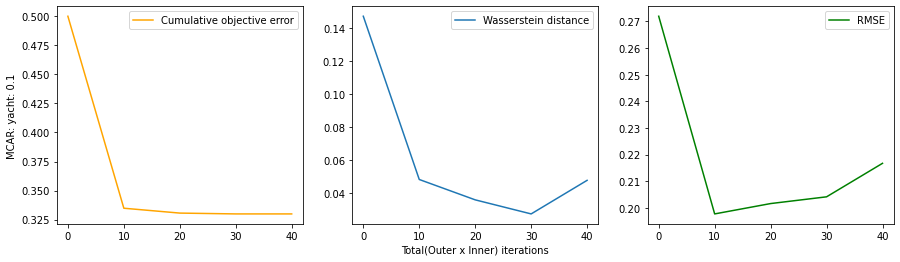

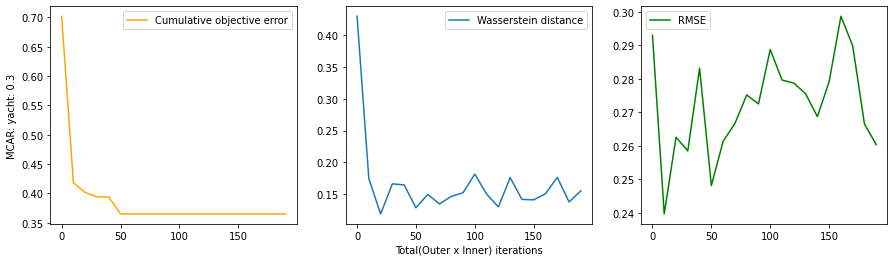

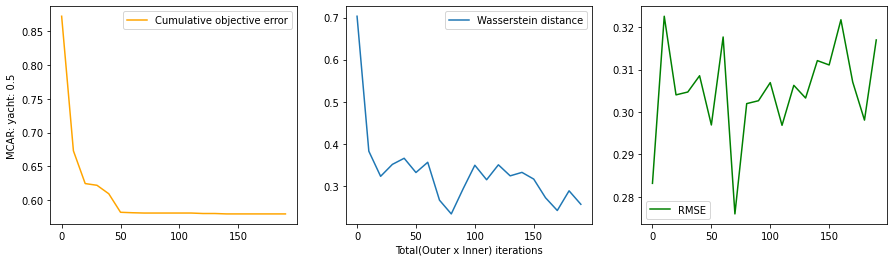

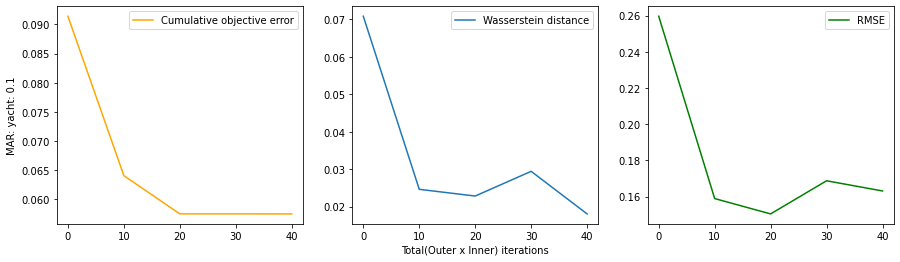

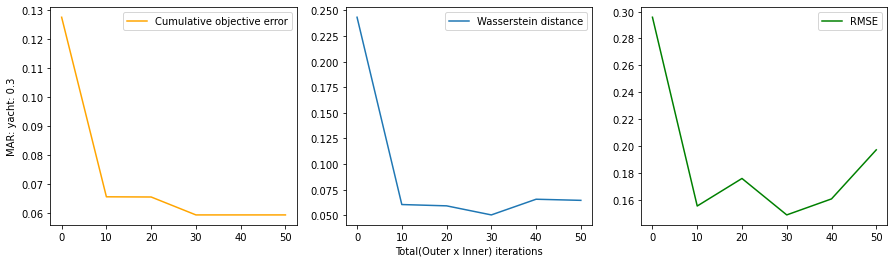

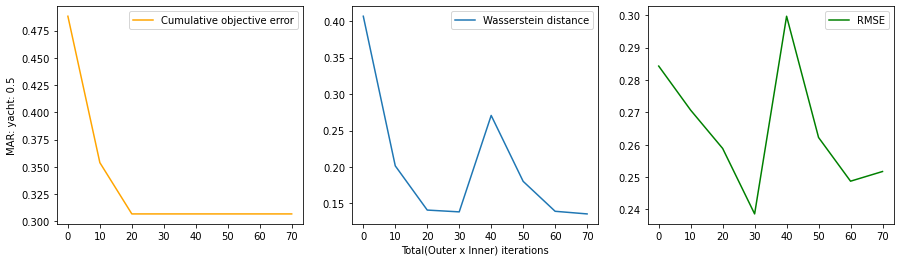

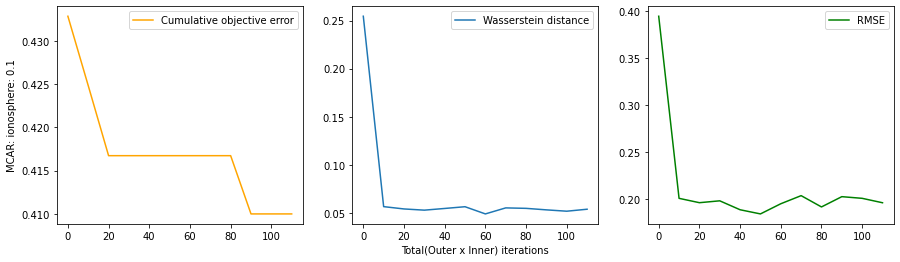

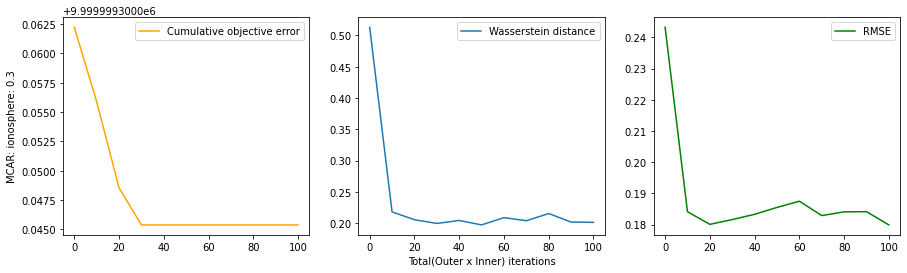

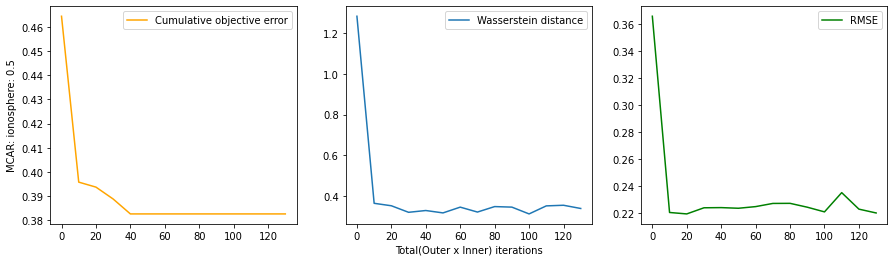

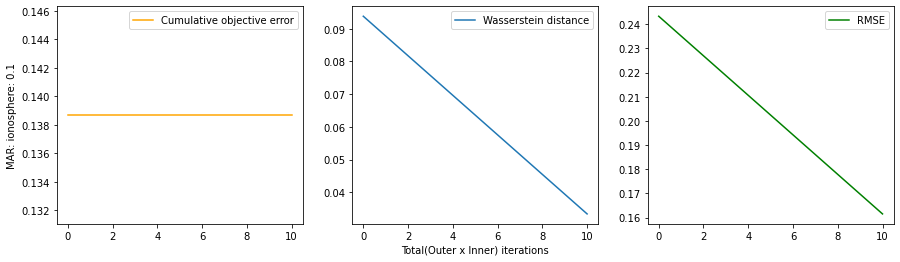

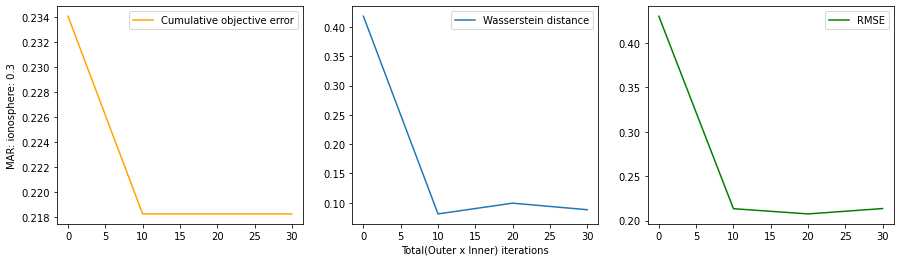

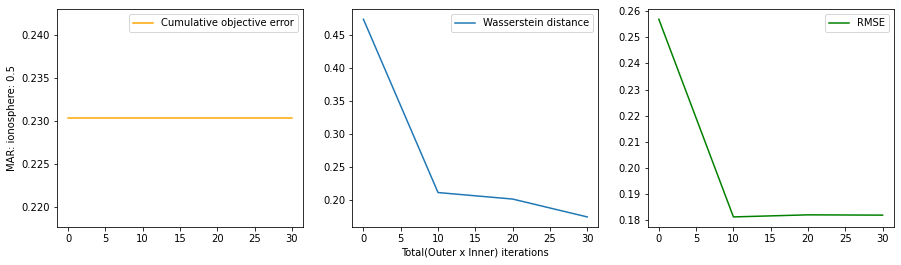

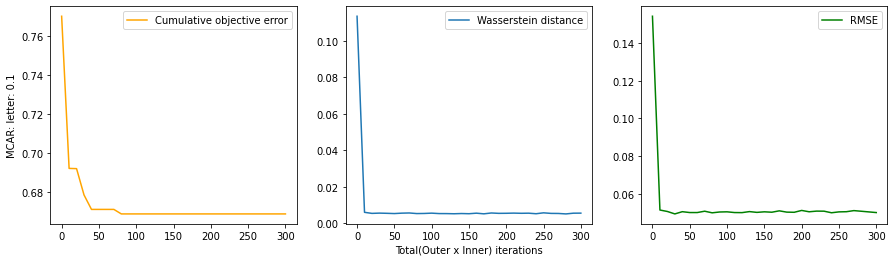

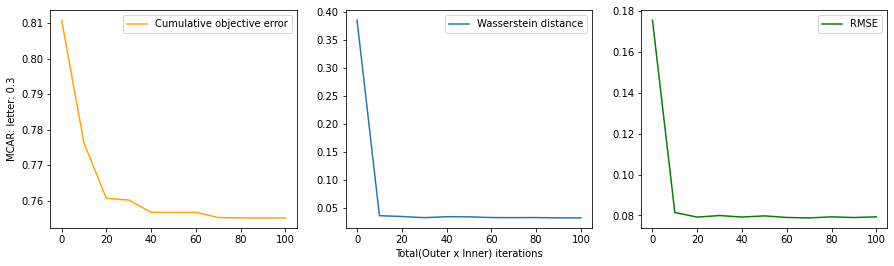

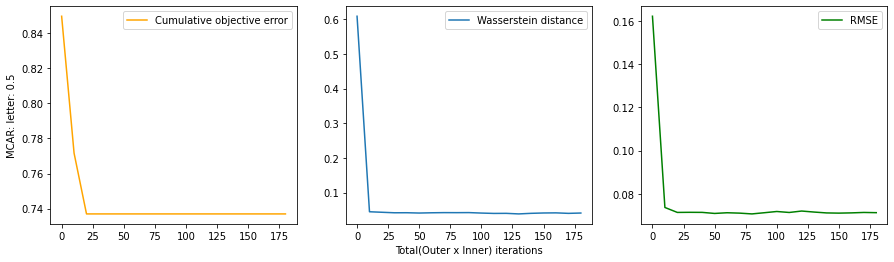

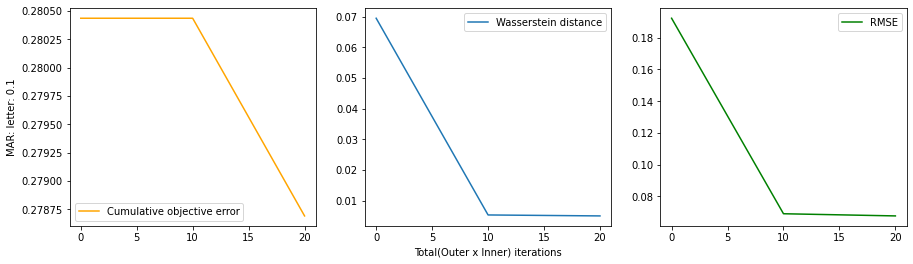

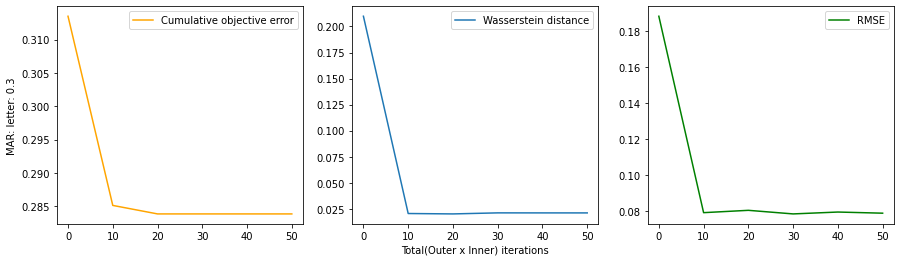

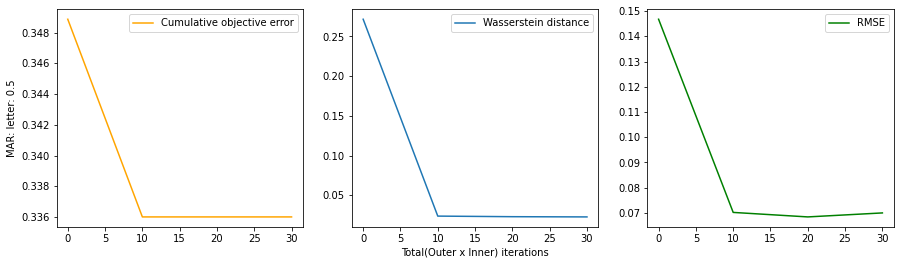

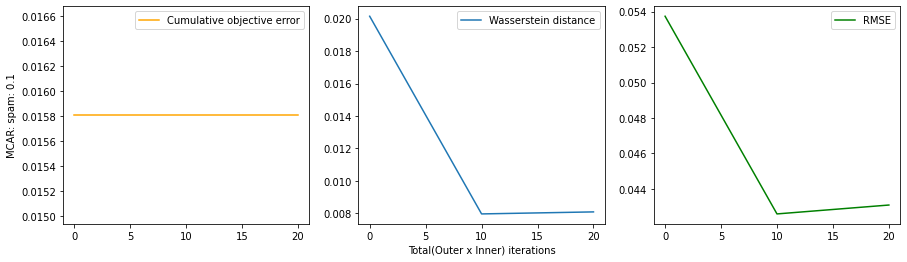

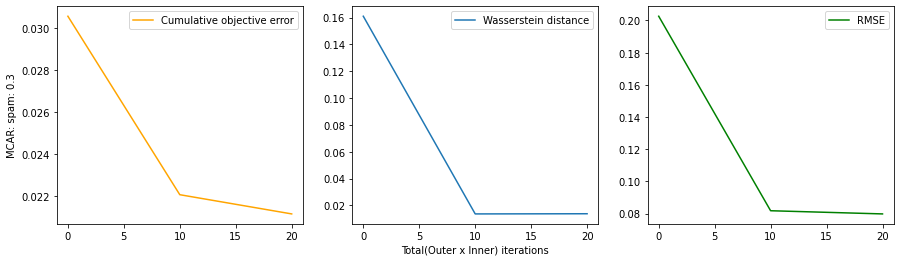

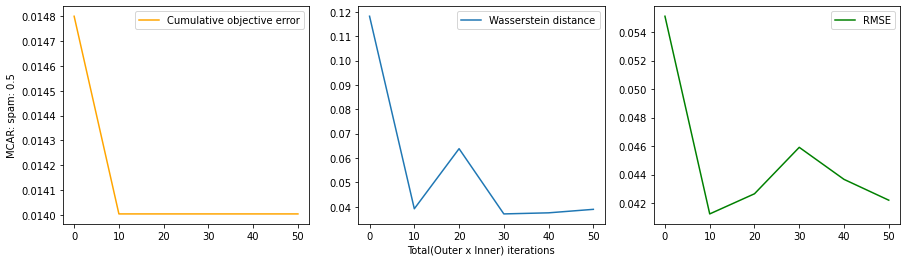

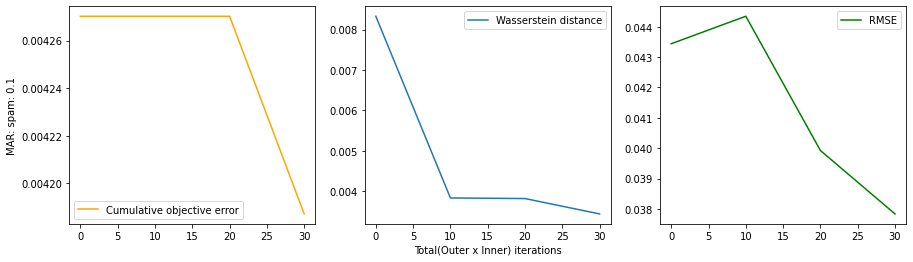

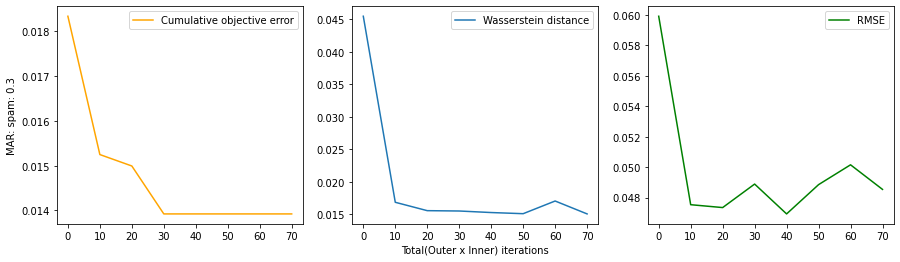

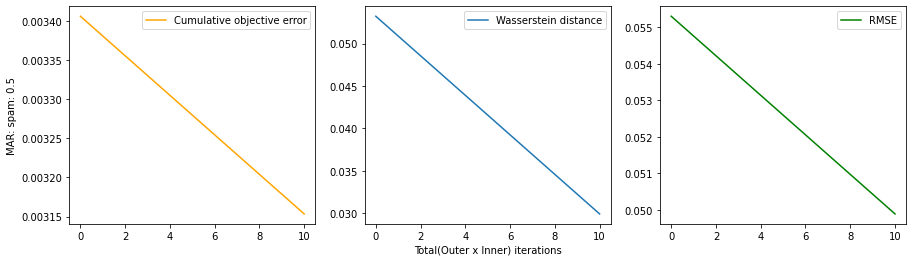

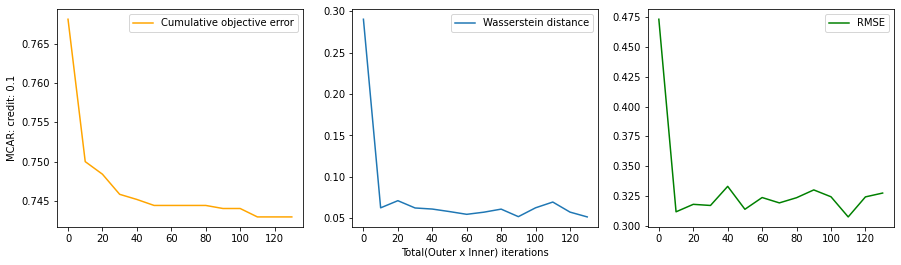

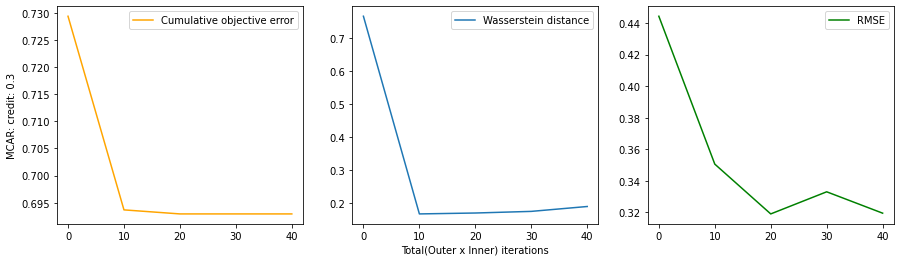

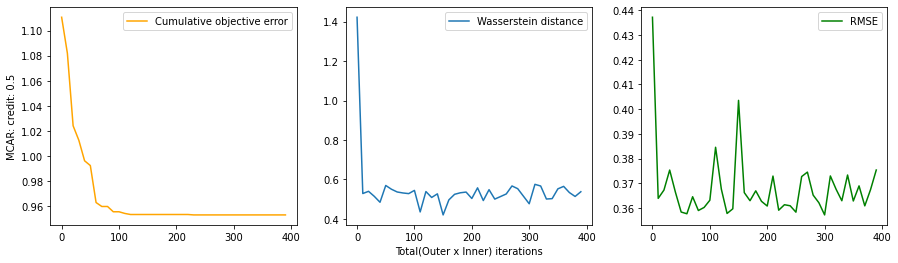

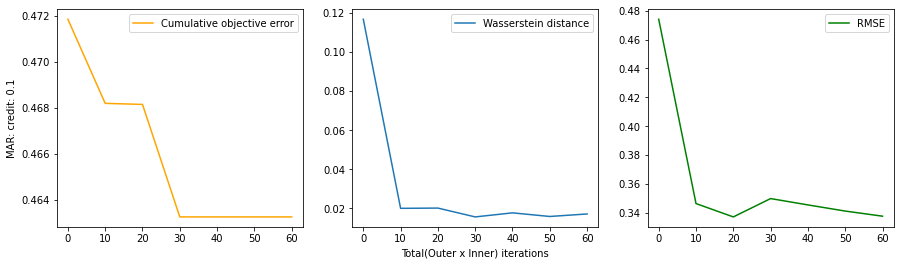

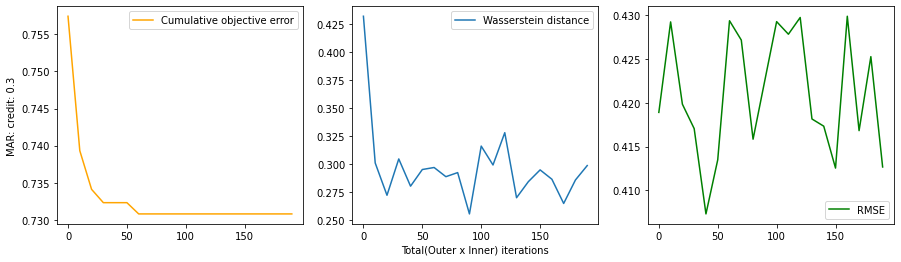

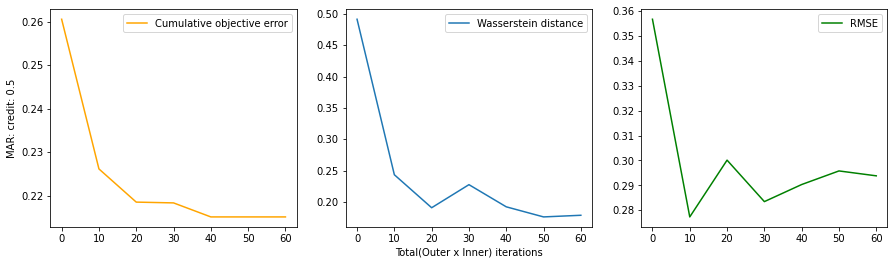

In [9]:
for dataset in raw_datasets:
    for scenario in ["MCAR", "MAR"]:
        for miss in [0.1, 0.3, 0.5]:
            try:
                perf_plot_dataset(dataset, scenario, miss)
            except BaseException as e:
                print("scenario failed", dataset, scenario, e)